In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from matplotlib import style
import seaborn as sns
%matplotlib inline

import env
import acquire as aq

# function calls

In [4]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

# import data

In [5]:
# function to pull data from sql
dfc = aq.get_logs_data(aq.get_connection)

In [6]:
df = dfc.copy()

In [7]:
df.head(1)

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,date,time,path,user_id,cohort_id,ip
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1,2018-01-26,09:55:03,/,1,8.0,97.105.19.61


In [8]:
pages = df.endpoint.resample('D').count()
pages.head()

AttributeError: 'DataFrame' object has no attribute 'endpoint'

# EMA

In [27]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()


In [28]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()


date
2018-01-26    435.000000
2018-01-27    290.357143
2018-01-28    234.448217
2018-01-29    359.129804
2018-01-30    389.360161
Freq: D, Name: endpoint, dtype: float64

In [29]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    435.000000
2018-01-27    295.500000
2018-01-28    241.597186
2018-01-29    351.922752
2018-01-30    379.925806
Freq: D, Name: endpoint, dtype: float64

In [30]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    435.000000
2018-01-27    298.500000
2018-01-28    245.851364
2018-01-29    348.213941
2018-01-30    374.710520
Freq: D, Name: endpoint, dtype: float64

# plot

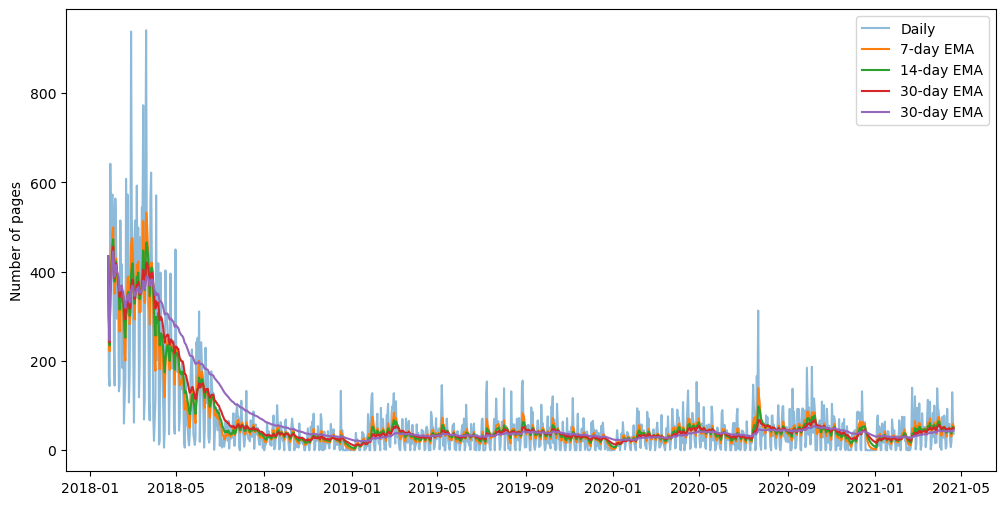

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

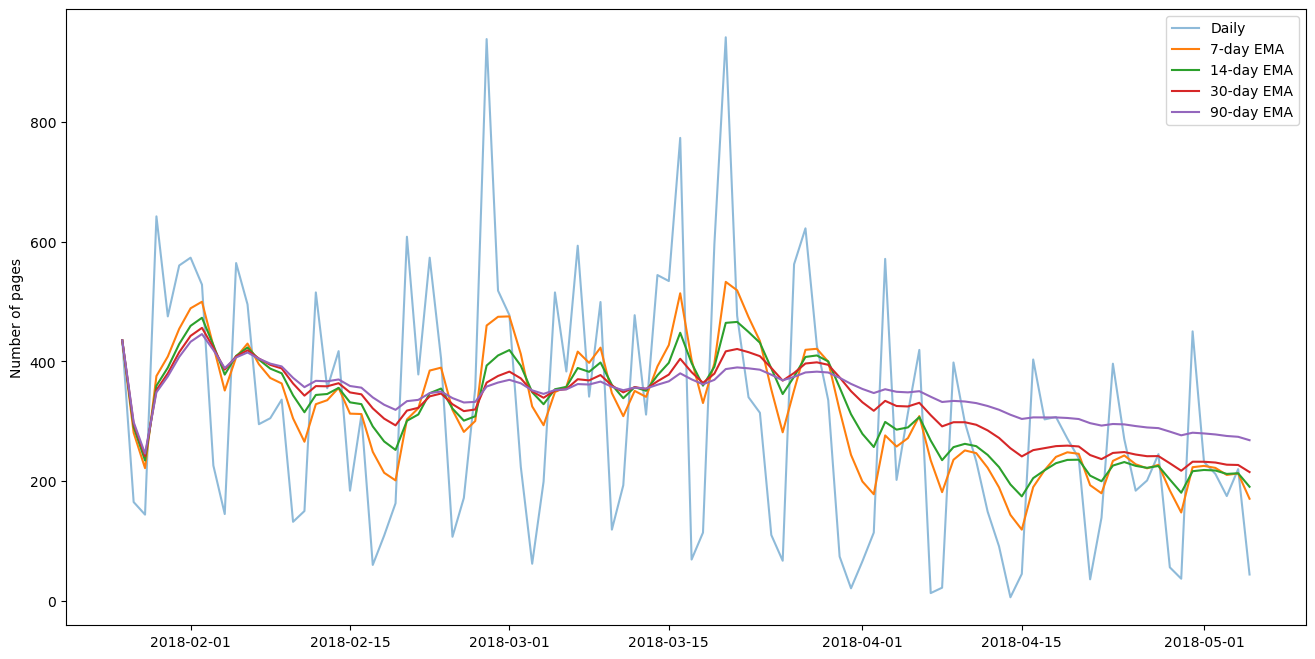

In [32]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

# bands

In [33]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()
midband

date
2018-01-26    435.000000
2018-01-27    295.500000
2018-01-28    241.597186
2018-01-29    351.922752
2018-01-30    379.925806
                 ...    
2021-04-17     44.433092
2021-04-18     42.856763
2021-04-19     48.478908
2021-04-20     49.738333
2021-04-21     48.916505
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [34]:
# compute stdev
stdev = pages.ewm(span=span).std()
stdev

date
2018-01-26           NaN
2018-01-27    190.918831
2018-01-28    159.750894
2018-01-29    243.290023
2018-01-30    214.979961
                 ...    
2021-04-17     35.059856
2021-04-18     34.455230
2021-04-19     39.808282
2021-04-20     38.810474
2021-04-21     37.672355
Freq: D, Name: endpoint, Length: 1182, dtype: float64

# upper and lower

In [35]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3 

In [37]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub,lb],axis=1) 
bb.columns = ['ub','lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,868.256493,-277.256493
2018-01-28,720.849867,-237.655495
2018-01-29,1081.792822,-377.947317
2018-01-30,1024.865690,-265.014078


In [38]:
# add to pages df
my_df = pd.concat([pages,midband,bb],axis=1)
my_df.columns = ['pages','midband','ub','lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,435,435.000000,NaN,NaN
2018-01-27,165,295.500000,868.256493,-277.256493
2018-01-28,144,241.597186,720.849867,-237.655495
2018-01-29,642,351.922752,1081.792822,-377.947317
2018-01-30,475,379.925806,1024.865690,-265.014078


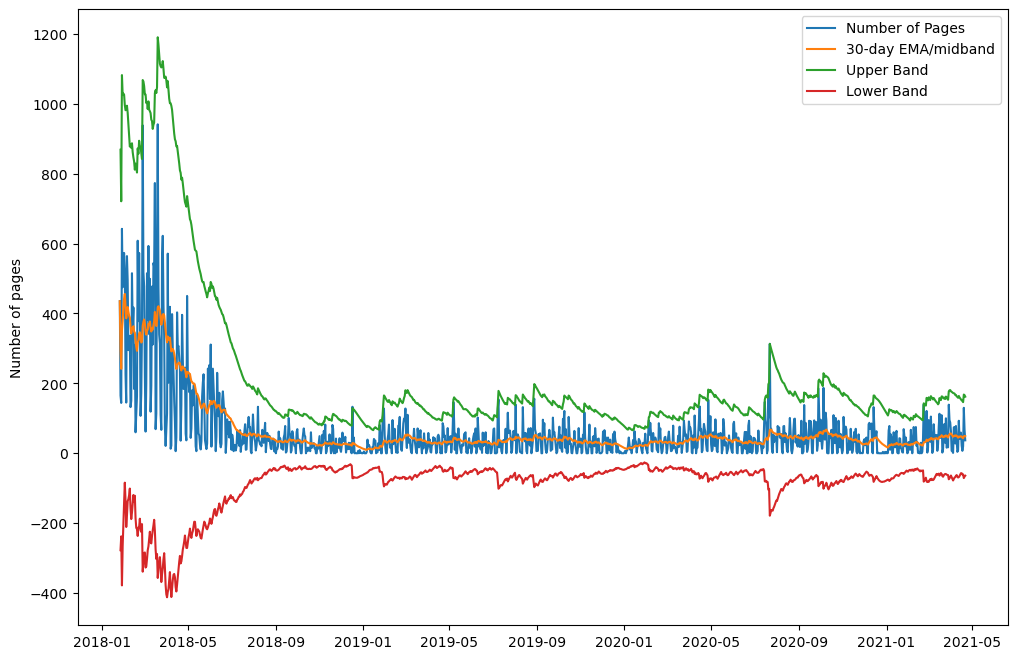

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


In [43]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head() 

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,435,435.000000,NaN,NaN,NaN
2018-01-27,165,295.500000,868.256493,-277.256493,0.386077
2018-01-28,144,241.597186,720.849867,-237.655495,0.398178
2018-01-29,642,351.922752,1081.792822,-377.947317,0.698718
2018-01-30,475,379.925806,1024.865690,-265.014078,0.573708


In [44]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-12-17,133,28.984715,129.123548,-71.154118,1.019355
2020-07-22,313,67.214983,312.946156,-178.516189,1.000110


# User Based

In [91]:
def acquire_logs(user=env.username, password=env.password, host=env.host):

    """
    This function retrieves data from the curriculum_logs database using the provided
    user credentials and host. It returns a pandas DataFrame with the date, endpoint, 
    user_id, cohort_id, and source_ip for each log entry.
    
    Args:
    - user (str): the username to connect to the database (default: env.username)
    - password (str): the password to connect to the database (default: env.password)
    - host (str): the host address to connect to the database (default: env.host)
    
    Returns:
    - df (pandas.DataFrame): a DataFrame with the log data
    """ 
    
    # create url from credentials
    url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
    # query to be sent to sql
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    
    '''
    # read-sql command with our query and url
    df = pd.read_sql(query, url)
    return df

In [93]:
def one_user_df_prep(df, user):
    
    """
    This function prepares a pandas DataFrame containing log data for a single user. 
    The DataFrame is filtered to only include log data for the specified user, and 
    the date column is converted to a datetime data type and set as the DataFrame's index. 
    The function then aggregates the data by day and counts the number of endpoints 
    accessed by the user each day. The resulting Series is returned.
    
    Args:
    - df (pandas.DataFrame): a DataFrame with log data
    - user (int): the user ID for the user to filter the data by
    
    Returns:
    - pages_one_user (pandas.Series): a Series with daily endpoint/ page counts for the specified user
    """
    
    # create a mask and a copy of our dataframe
    df = df[df.user_id == user].copy()
    
    # create datetime object
    df.date = pd.to_datetime(df.date)
    
    # set index using datetime
    df = df.set_index(df.date)
    
    # create a list of end paths and resample them by day, create dataframe
    
    pages_one_user = df['endpoint'].resample('d').count()
    
    # return df
    return pages_one_user

In [101]:
def compute_pct_b(pages_one_user, span, weight, user):
    
    """
    This function computes the percent bandwidth (pct_b) for a single user's log data, 
    which is a measure of how far away the user's activity is from the moving average 
    of the activity. The function takes a Series with daily endpoint counts for a user, 
    a span for the moving average, a weight for the standard deviation used to calculate 
    the upper and lower bands, and the user ID. The function calculates the midband, 
    standard deviation, upper band, and lower band for the data, concatenates these 
    into a DataFrame, and calculates the pct_b using the upper and lower bands and the 
    daily endpoint counts. The resulting DataFrame includes the daily endpoint counts, 
    midband, upper and lower bands, pct_b, and user ID for each day.
    
    Args:
    - pages_one_user (pandas.Series): a Series with daily endpoint counts for a single user
    - span (int): the span for the moving average used to calculate the midband and standard deviation
    - weight (float): the weight for the standard deviation used to calculate the upper and lower bands
    - user (int): the user ID for the user whose data is being analyzed
    
    Returns:
    - my_df (pandas.DataFrame): a DataFrame with daily endpoint counts, midband, upper and lower bands, 
      pct_b, and user ID for the specified user
    """
     
   
    # calculate the midband, standard deviation, upper band, and lower band using exponential 
    # weighted moving averages           
    midband = pages_one_user.ewm(span=span).mean()
    
    stdev = pages_one_user.ewm(span=span).std()
                
    # creating upper and lowerband using the midband and stdev
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # concat the upper and lower band
    bb = pd.concat([ub, lb], axis=1)
            
    # concatenate the daily endpoint counts, midband, and upper and lower bands into a DataFrame
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    
    # naming the columns
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # calculate the pct_b using the upper and lower bands and the daily endpoint counts
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    
    # adding user number to applied to the user_id column
    my_df['user_id'] = user
    return my_df

In [123]:
def plot_bands(my_df, user):
    '''
    This function plots the percent bandwidth (pct_b) bands for a single user's log data,
    which provide a visual representation of how far away the user's activity is from the 
    moving average of the activity. The function takes a DataFrame with daily endpoint counts,
    midband, upper and lower bands, pct_b, and user ID for a single user, and the user ID.
    The function plots the daily endpoint counts, midband, and bands over time using Matplotlib.
    
    Args:
    - my_df (pandas.DataFrame): a DataFrame with daily endpoint counts, midband, upper and lower bands, 
      pct_b, and user ID for a single user
    - user (int): the user ID for the user whose data is being plotted
    
    Returns:
    - None
    '''
    # creating subplots
    fig, ax = plt.subplots(figsize=(12,8))
    # plotting different series for comparison
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    # plot legend in specific location
    ax.legend(loc='best')
    # label y label
    ax.set_ylabel('Number of Pages')
    
    plt.show()

In [132]:
def find_anomalies(df, user, span, weight, plot=False):
    '''
    
    This function finds anomalous activity in a single user's log data using percent bandwidth (pct_b) bands. 
    The function takes a DataFrame with date, endpoint, user ID, cohort ID, and source IP columns,
    the user ID, the span parameter for the exponential moving average, the weight parameter for the 
    standard deviation multiplier, and a boolean value indicating whether to plot the data or not.
    The function calculates the daily endpoint counts, midband, upper and lower bands, pct_b, and user ID 
    using the one_user_df_prep and compute_pct_b functions. If plot=True, the function also calls the plot_bands 
    function to plot the daily endpoint counts, midband, and bands over time using Matplotlib. 
    The function returns a DataFrame with the same columns as my_df, but only including rows where the pct_b 
    value is greater than 1, indicating anomalous activity.
    
    Args:
    - df (pandas.DataFrame): a DataFrame with date, endpoint, user ID, cohort ID, and source IP columns
    - user (int): the user ID for the user whose data is being analyzed
    - span (int): the span parameter for the exponential moving average used to calculate the midband and 
      standard deviation of the daily endpoint counts
    - weight (int): the weight parameter for the standard deviation multiplier used to calculate the upper 
      and lower bands of the pct_b bands
    - plot (bool): whether to plot the daily endpoint counts, midband, and pct_b bands over time or not. 
      Default is False.
      
    Returns:
    - pandas.DataFrame: a DataFrame with the same columns as my_df, but only including rows where the pct_b 
      value is greater than 1, indicating anomalous activity.

    '''
    pages_one_user = one_user_df_prep(df, user)
    
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    if plot:
        plot_bands(my_df, user)
    
    return my_df[my_df.pct_b>1]

In [60]:
df = acquire_logs()
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [ ]:
user=1
span=30
weight=6

In [62]:
# calling function
find_anomalies(df, user, span, weight)
# no anomalies found user one

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,


In [64]:
# loop through the users
weight = 3.5

anomalies = pd.DataFrame()

for u in df.user_id.unique():

    one_user = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, one_user])

In [74]:
# 1060 anamolies
anomalies.head(5)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3


In [71]:
# these users have the most anomalies
anomalies.user_id.value_counts()

88     12
146    11
80     11
18     10
291     9
       ..
526     1
527     1
528     1
206     1
859     1
Name: user_id, Length: 413, dtype: int64

In [75]:
anomalies.sort_values('pct_b', ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-12-24,1,0.064516,0.939061,-0.810028,1.034841,232
2020-12-16,12,0.774194,11.268729,-9.720342,1.034841,156
2020-09-13,4,0.258065,3.756243,-3.240114,1.034841,210
2020-05-12,16,1.032258,15.024972,-12.960456,1.034841,93
2019-09-12,16,1.032258,15.024972,-12.960456,1.034841,94
...,...,...,...,...,...,...
2021-03-23,146,26.440411,145.913292,-93.032470,1.000363,581
2020-09-17,24,2.103030,23.984360,-19.778300,1.000357,560
2020-10-27,17,1.232625,16.991469,-14.526220,1.000271,613


In [125]:
anomalies.sort_values('pages_one_user', ascending=False).tail(1)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2020-03-16,1,0.064566,0.940141,-0.81101,1.034183,200


# takes this info and relate it back the dataframe

In [129]:
df[df.user_id==341]

,date,endpoint,user_id,cohort_id,source_ip
181808,2019-01-22,/,341,29.0,97.105.19.58
181826,2019-01-22,toc,341,29.0,97.105.19.58
181840,2019-01-22,html-css,341,29.0,97.105.19.58
181862,2019-01-22,html-css/introduction,341,29.0,97.105.19.58
181870,2019-01-22,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...
817183,2021-02-09,search/search_index.json,341,29.0,172.124.70.146
817184,2021-02-09,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
817268,2021-02-10,appendix/code-standards/mysql,341,29.0,172.124.70.146
817269,2021-02-10,appendix/further-reading/spring/pagination,341,29.0,172.124.70.146


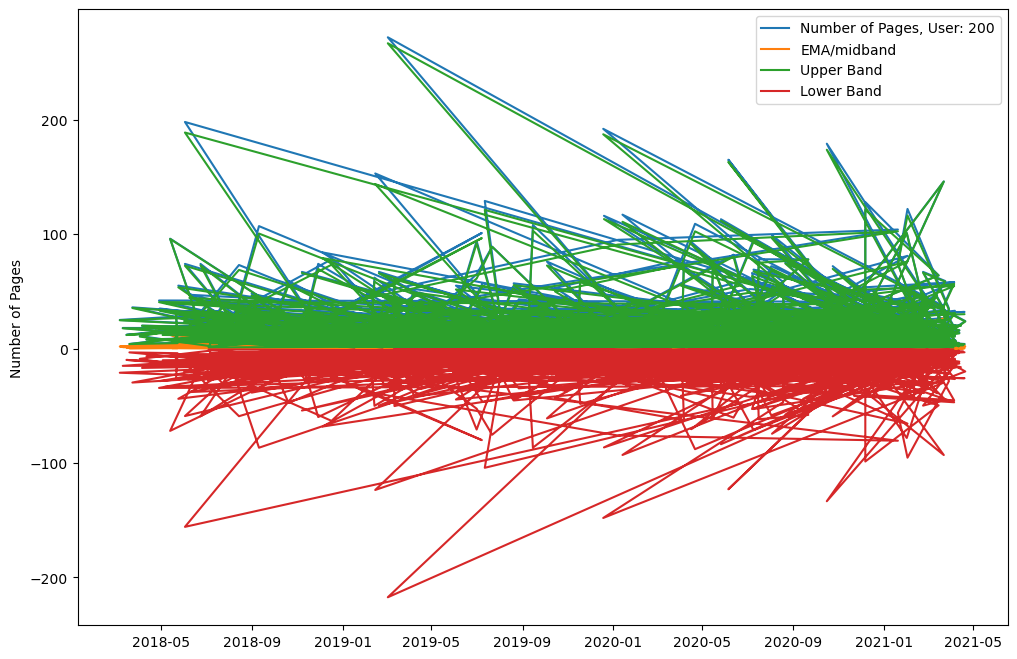

In [135]:
plot_bands(anomalies, 200)
    
